In [1]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from numpy import genfromtxt
import numpy as np
from pak.evaluation import MOTA
from cabbage.data.video import VideoData
from experiments import MOT16_Experiments
from time import time

root = Settings['data_root']

mot16 = MOT16_Experiments(root)

print("check:")
print(mot16.mot16_11_detections.shape)
print("")



__start = time()
result = genfromtxt('../build/RESULT.txt', delimiter=' ', dtype='uint32')
__end = time()
print('elapsed', __end - __start)
print('load results:', result.shape)



def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

__start = time()
Nodes = extract_ids(result)
__end = time()
print('elapsed', __end - __start)
print('finished extracting ids')

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

print("Unique ids:", n_unique)
print("total nodes:", len(Nodes))

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}
check:
(8125, 6)

elapsed 222.81617641448975
load results: (33003750, 3)
elapsed 90.13696122169495
finished extracting ids
Unique ids: 494
total nodes: 8125


/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
before (8125, 7)
after (4942, 7)

unique GT: 27

unique DT: 61

GT (2601, 6)
MOTA: 0.170319108035
	info: {'FN': 182, 'FP': 1973, 'IDSW': 3, 'GT': 2601}

	 FN/FP ratio: 0.0922453117081



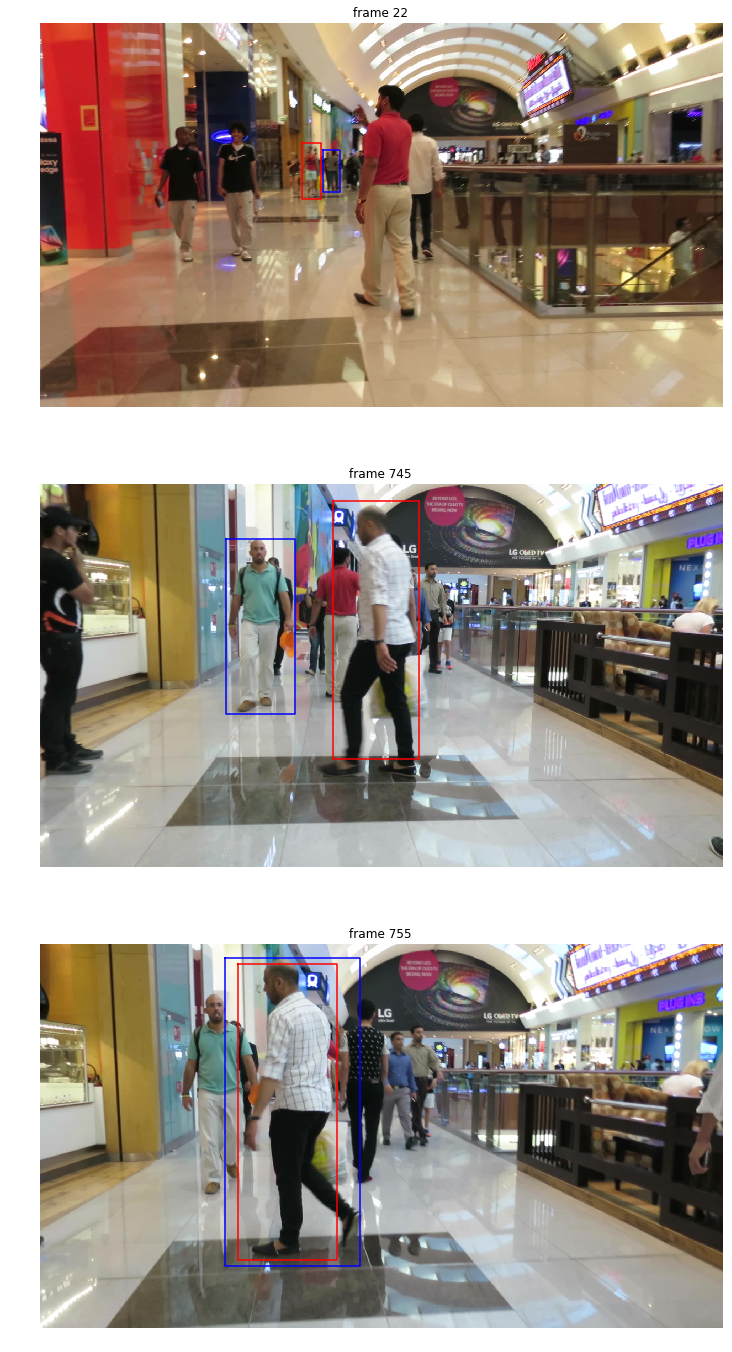

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
from pak.datasets.MOT import MOT16
root = Settings['data_root']
mot16__ = MOT16(root)
from pak import utils

X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

from pak.post_processing import MOT
ALL_DETECTIONS = mot16.mot16_11_detections[0:len(Nodes)]  # as we do not need all frames..
#ALL_DETECTIONS = mot16.mot16_11_true_detections_no_pid[0:len(Nodes)]  # as we do not need all frames..

# Hy = mot16.get_MOT16_11_trajectories()  # true detections
# print(Hy.shape)

Dt = []
for i, (pid, data) in enumerate(zip(Nodes, ALL_DETECTIONS)):
    frame, x, y, w, h, score = data
    Dt.append((frame, pid, x, y, w, h, score))
Dt = np.array(Dt)


CULL_LEVEL = 4
print("before", Dt.shape)
Dt = MOT.remove_short_tracks(
    MOT.remove_duplicates(Dt, lambda x: x[6]),
    min_length=CULL_LEVEL)
print('after', Dt.shape)

Gt = MOT.remove_short_tracks(Gt, min_length=CULL_LEVEL)


print("\nunique GT:", len(np.unique(Gt[:,1])))
print("\nunique DT:", len(np.unique(Dt[:,1])))
print('')

# print("after", Dt.shape)
Dt = Dt[:,0:6]

# print(Dt[0:6].astype('object'))
# Dt_f1 = utils.extract_eq(Dt, col=0, value=1)
# Dt_f2 = utils.extract_eq(Dt, col=0, value=2)
# print("qq", Dt_f2.shape)


Gt = mot16.get_MOT16_11_gt_trajectories()
Gt = MOT.remove_short_tracks(Gt, min_length=CULL_LEVEL)
TILL= 795
vd = VideoData(Gt); Gt = vd.get_n_first_frames(TILL)
vd = VideoData(Dt); Dt = vd.get_n_first_frames(TILL)

print("GT", Gt.shape)

threshold=0.5
result, info, debug = MOTA.evaluate_aabb(Gt, Dt, threshold, 
                                  info=True, debug_info=True)


print("MOTA:", result)
print("\tinfo:", info)
print("\n\t FN/FP ratio:", info['FN']/info['FP'])
print("")
N_idsw = len(debug['IDSW'])

fig = plt.figure(figsize=(16,8*N_idsw))

for i, idsw in enumerate(debug['IDSW']):
    A = Gt[idsw[0]]; B = Dt[idsw[1]]
    assert A[0] == B[0]; frame = int(A[0])
    img = X[frame-1]
    bb1 = A[2:].astype('int32'); bb2 = B[2:].astype('int32')
    
    
    ax = fig.add_subplot(N_idsw, 1, i+1)
    ax.set_title('frame ' + str(frame)); ax.imshow(img)
    bbX, bbY = utils.bb_to_plt_plot(*bb1); ax.plot(bbX, bbY, color='blue')
    bbX, bbY = utils.bb_to_plt_plot(*bb2); ax.plot(bbX, bbY, color='red')
    ax.axis('off')

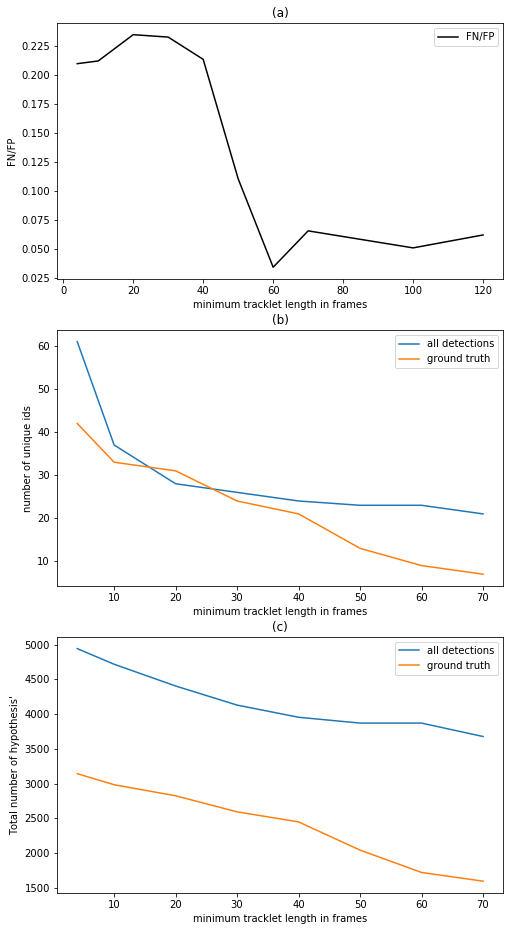

In [159]:
FN_count = [509, 517, 608, 694, 762, 774, 774, 911]
FP_count = [2261, 2044, 1822, 1633, 1526, 1454, 1454, 1398]
FN_FP_ratio = [
    0.209833187006,
    0.212176283507,
    0.234866828087,
    0.232767232767,
    0.213577023499,
    0.110462287105,
    0.0341419586703,
    0.0655296229803,
    0.0508333333333,
    0.0619918699187]
TOT_count = [4942, 4717, 4404, 4129, 3954, 3870, 3870, 3677]
TOT_count_gt = [3142, 2983, 2824, 2593, 2448, 2042, 1720, 1595]
UNIQ_count = [61, 37, 28, 26, 24, 23, 23, 21]
UNIQ_count_gt = [42, 33, 31, 24, 21, 13, 9, 7]
Cull_length = [4, 10, 20, 30, 40, 50, 60, 70]

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(312); 
ax.plot(Cull_length, UNIQ_count, label='all detections');
ax.set_xlabel('minimum tracklet length in frames'); ax.set_ylabel('number of unique ids')
ax.plot(Cull_length, UNIQ_count_gt, label='ground truth');
ax.set_title('(b)')
ax.legend()

ax = fig.add_subplot(311);
ax.set_xlabel('minimum tracklet length in frames'); 
ax.set_ylabel('FN/FP')
ax.plot(Cull_length + [ 100, 120], FN_FP_ratio, label='FN/FP', color='black')
ax.set_title("(a)")
ax.legend()


ax = fig.add_subplot(313); ax.plot(Cull_length, TOT_count, label='all detections');
ax.set_xlabel('minimum tracklet length in frames'); ax.set_ylabel('Total number of hypothesis\'')
ax.plot(Cull_length, TOT_count_gt, label='ground truth');
ax.set_title('(c)')

ax.legend()
plt.savefig('mot16_11_increase_track_cull.eps', format='eps', dpi=1000)
#plt.show()

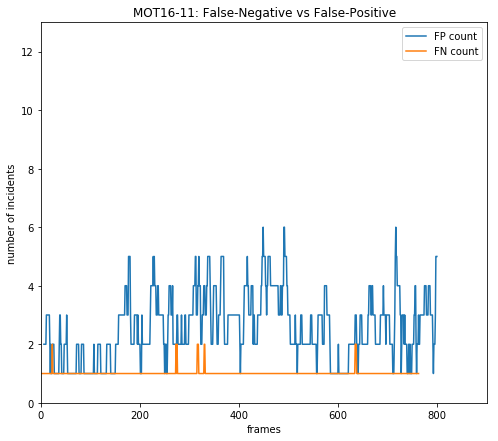

In [162]:
FP_pairs = debug['FP']
FP_frames = FP_pairs[:,0]

FN_pairs = debug['FN']
FN_frames = FN_pairs[:,0]

Fr_fp, Co_fp = np.unique(FP_frames, return_counts=True)
Fr_fn, Co_fn = np.unique(FN_frames, return_counts=True)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111);ax.set_ylim([0, 13]); ax.set_xlim([0, 902])
ax.plot(Fr_fp, Co_fp, label='FP count'); ax.plot(Fr_fn, Co_fn, label='FN count')
ax.set_xlabel('frames'); ax.set_ylabel('number of incidents')
ax.set_title("MOT16-11: False-Negative vs False-Positive")

ax.legend()
plt.savefig('mot16_11_fn_fp_graph.eps', format='eps', dpi=1000)
#plt.show()

/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded


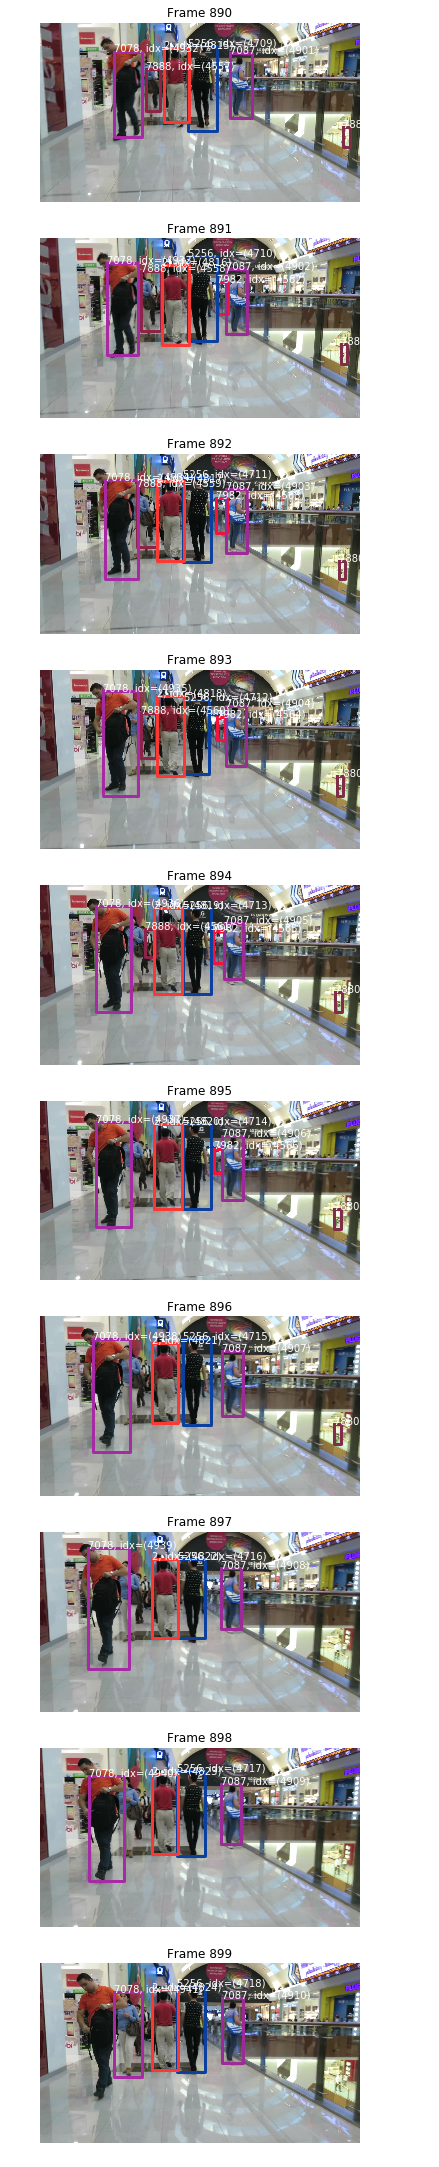

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from pak import utils
from cselect import color as cs
from pak.datasets.MOT import MOT16
mot16__ = MOT16(root)

X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

n_unique = len(np.unique(Nodes))
colors = cs.lincolor(n_unique, random_sat=True, random_val=True)
COLOR_LOOKUP = {}
for pid, color in zip(np.unique(Nodes), colors):
    COLOR_LOOKUP[str(pid)] = color

frames = range(890, 900)
# plt.imshow(X[0])

# Y_f1 = utils.extract_eq(mot16.mot16_11_detections, 
#                                col=0, value=2)

# print(Y_f1.shape)
# for idx, (_, x, y, w, h, _) in enumerate(Y_f1):
#     bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
#     plt.text(x, y, str(idx), color='white')
#     plt.plot(bbX, bbY, linewidth=3)

fig = plt.figure(figsize=(13,13*3))
_h = len(frames); _w = 1
for idx, f in enumerate(frames):
    ax = fig.add_subplot(_h,_w,idx+1)
    ax.imshow(X[f])
    #Y_f1 = utils.extract_eq(Dt, col=0, value=f)
    for idx, (f_, pid, x, y, w, h) in enumerate(Dt):
        if f == f_:
            color = COLOR_LOOKUP[str(int(pid))]
            bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
            ax.text(x, y, str(int(pid)) + ", idx=(" + str(idx) + ")", color='white')
            ax.plot(bbX, bbY, linewidth=3, color=color/255)
            ax.set_title('Frame ' + str(f))
            ax.axis('off')
        

plt.show()

(3, 6)
(8, 6)


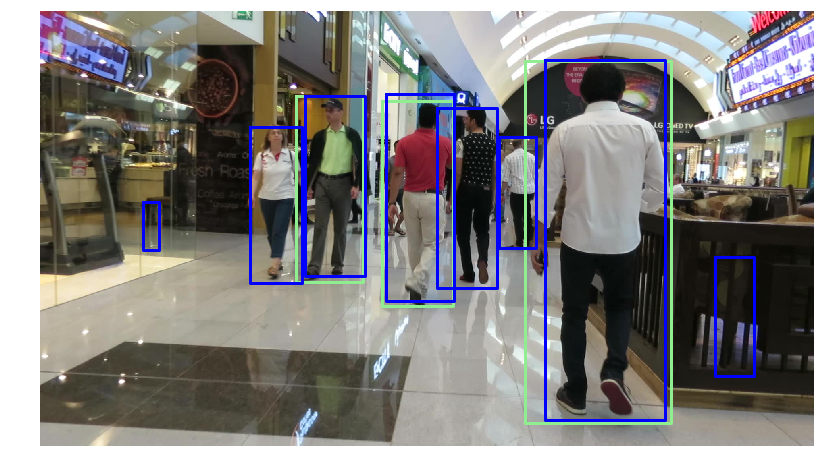

In [34]:
FRAME = 496

I = X[FRAME-1]



fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111); ax.imshow(I); ax.axis('off')

GT_lf = utils.extract_eq(Gt, col=0, value=FRAME)
DT_lf = utils.extract_eq(Dt, col=0, value=FRAME)
print(GT_lf.shape)
print(DT_lf.shape)
for _, _, x, y, w, h in GT_lf:
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, color='lightgreen')
    
for _, _, x, y, w, h in DT_lf:
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, color='blue')

plt.show()